In [1]:
from backbones.sana import SANA

model = SANA()
print(model)

/home/lee08/miniconda3/envs/comfyui/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

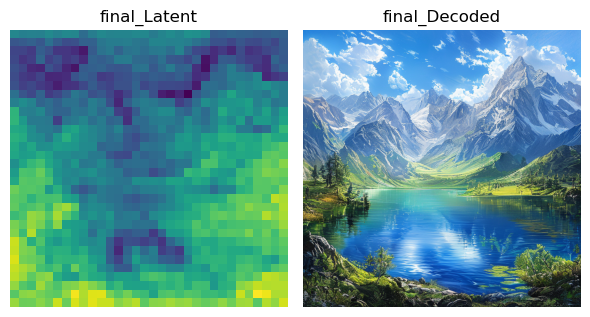

In [2]:
import matplotlib.pyplot as plt
import torch
from solvers.common_lee import *
from solvers.euler_solver import Euler_Solver
from solvers.dpm_solver import DPM_Solver
from solvers.heun_solver import Heun_Solver

pos_text =  "a beautiful landscape with mountains and lake, masterpiece, high quality"
neg_text = "ugly, blurry, low quality"
# 1) 모든 매개변수들을 먼저 변수로 설정
guidance_scale = 4.5
num_steps = 10
seed = 42
steps = 100
flow_shift=3.0
model_fn, noise_schedule, latents = model.get_model_fn(pos_text=pos_text, neg_text=neg_text, guidance_scale=guidance_scale, num_steps=num_steps, seed=seed)

collector_euler = StateCollector()  #중간 상태 확인
solver_1 = Euler_Solver(model_fn, noise_schedule)
latent_samples = solver_1.sample(latents, steps=steps, skip_type='time_uniform_flow', flow_shift=flow_shift, callback=collector_euler)
pixel_samples = model.decode_vae(latent_samples)
euler_sample = pixel_samples[0]

show_latent_vs_decoded(latent_samples, euler_sample,
                       name1="final_Latent", name2="final_Decoded")

Total number of steps: 100


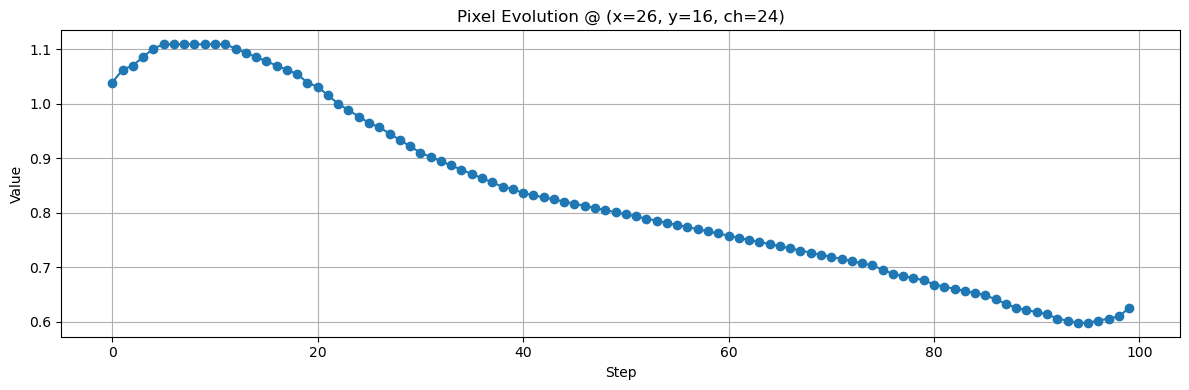


Statistics:
  Initial : 1.0391
  Final   : 0.6250
  Min/Max : 0.5977 / 1.1094
  Delta   : -0.4141
Total number of steps: 100


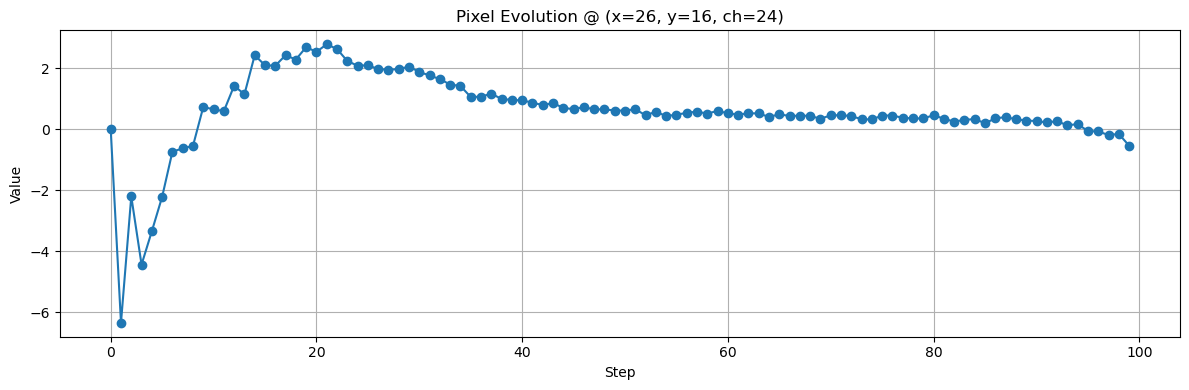


Statistics:
  Initial : -0.0000
  Final   : -0.5391
  Min/Max : -6.3438 / 2.7812
  Delta   : -0.5391


In [ ]:
pixel_x=26
pixel_y=16
channel=24
plot_single_state_pixel(collector_euler.states, pixel_x=pixel_x, pixel_y=pixel_y, channel=channel)
plot_single_state_pixel(collector_euler.gradients, pixel_x=pixel_x, pixel_y=pixel_y, channel=channel)

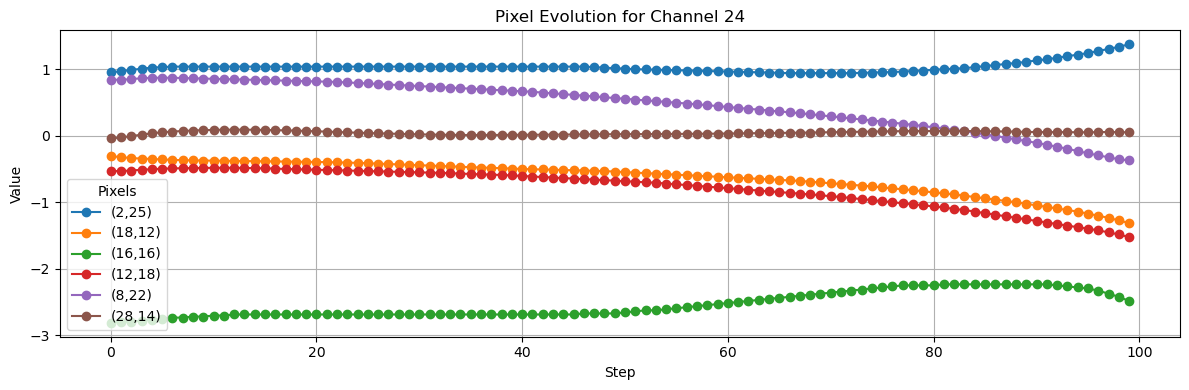

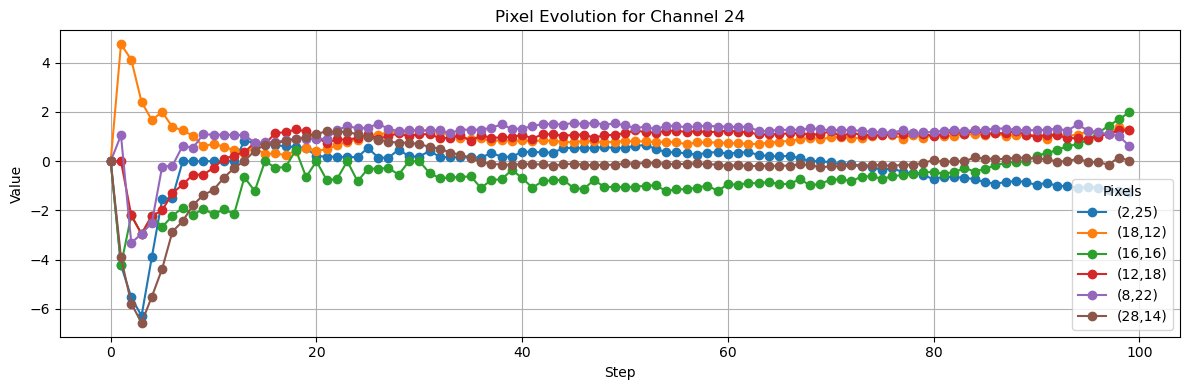

In [ ]:
pixel_positions = [
    (2, 25),
    (18, 12),
    (16,16),   
    (12, 18),  
    (8, 22),
    (28, 14),
]
plot_multiple_state_pixels(collector_euler.states, pixel_positions, channel=24)
plot_multiple_state_pixels(collector_euler.gradients, pixel_positions, channel=24)

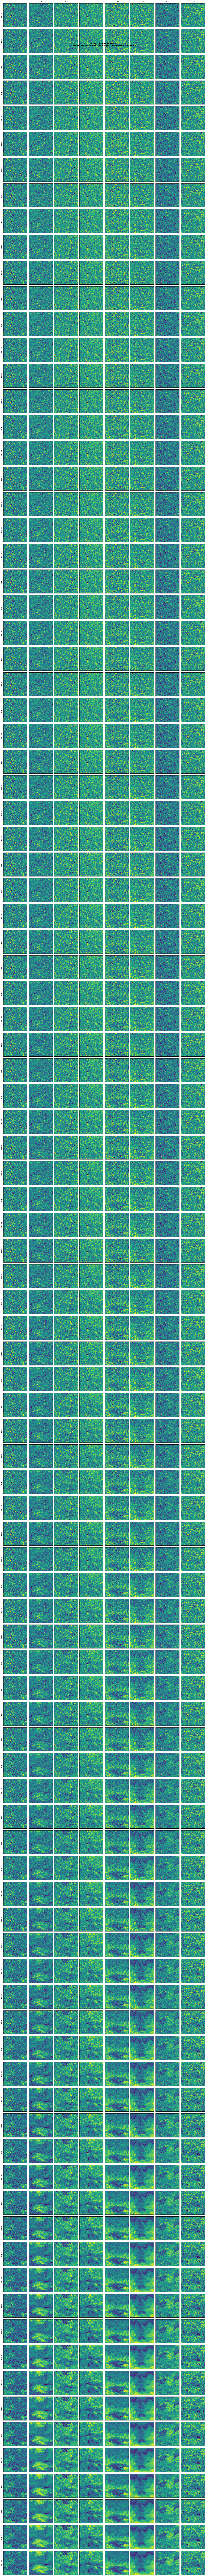

In [ ]:
import matplotlib.pyplot as plt
import torch

# 전체 step에서, 보고 싶은 채널 리스트의 변화 보기기
n_steps = len(collector_euler.states)  # 실제 수집된 스텝 수
channels = [5,6,7,9,20,24,27,30]      # 보고 싶은 특정 채널 인덱스

# 배치 차원 제거 + bfloat16 → float32 캐스트
def get_channel_image(state, ch):
    lt = state.squeeze(0)           # [C, H, W]
    if lt.dtype == torch.bfloat16:
        lt = lt.to(torch.float32)
    img = lt[ch].cpu().numpy()      # [H, W]
    return img

# 1) n_steps × len(channels) 그리드 생성
fig, axes = plt.subplots(n_steps, len(channels), 
                         figsize=(2*len(channels), 2*n_steps),
                         squeeze=False)
# 실험 정보 포함
fig.suptitle(f'Latent Space Analysis\n'
             f'Method: Heun Solver | All Steps | Interested Channels\n',
             #f'Shape: {latent.shape} | dtype: {latent.dtype}', 
             fontsize=12, fontweight='bold')
# 2) 각 셀에 이미지 플롯
for i in range(n_steps):
    for j, ch in enumerate(channels):
        ax = axes[i][j]
        img = get_channel_image(collector_euler.states[i], ch)
        ax.imshow(img, cmap='viridis')
        ax.set_xticks([])
        ax.set_yticks([])
        # 타이틀: 첫 행엔 채널 번호, 첫 열엔 스텝 번호
        if i == 0:
            ax.set_title(f"ch {ch}", fontsize=8)
        if j == 0:
            ax.set_ylabel(f"step {i}", fontsize=8)
        
plt.tight_layout()
plt.show()
